In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Load datasets with empty strings treated as NaN
df_climate = pd.read_csv('../data/climate_scores.csv', na_values=[''])
df_cost = pd.read_csv('../data/cost_of_life_capitals.csv', na_values=[''])
df_coworking = pd.read_csv('../data/coworking_capitals.csv', na_values=[''])
df_death = pd.read_csv('../data/death_per_capital_2023.csv', na_values=[''])
df_internet = pd.read_csv('../data/internet_quality_capitals.csv', na_values=[''])
df_ips = pd.read_csv('../data/ips_capitals.csv', na_values=[''])

# Standardize city names
for df in [df_climate, df_cost, df_coworking, df_death, df_internet, df_ips]:
    if 'City' in df.columns:
        df['City'] = df['City'].str.strip()
    elif 'capital' in df.columns:
        df['capital'] = df['capital'].str.strip()
    elif 'Capital' in df.columns:
        df['Capital'] = df['Capital'].str.strip()

# Merge all datasets on 'City'
df_merged = (
    df_cost.merge(df_climate, on='City', how='left')
    .merge(df_internet.rename(columns={'city': 'City'}), on='City', how='left')
    .merge(df_coworking.rename(columns={'capital': 'City'}), on='City', how='left')
    .merge(df_death.rename(columns={'Capital': 'City'}), on='City', how='left')
    .merge(df_ips.rename(columns={'Município': 'City'}), on='City', how='left')
)

# Drop duplicates
df_merged.drop_duplicates(subset=['City'], keep='first', inplace=True)

# Define relevant columns for scoring
key_columns = [
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)',
    'Public Transport (Monthly)', 'Índice de Progresso Social',
    'Moradia', 'Saúde e Bem-estar', 'Água e Saneamento',
    'Nutrição e Cuidados Médicos Básicos', 'speed_mbps',
    'Segurança Pessoal', 'Taxa_2023', 'Climate Score'
]

# Filter out rows with too many missing values
df_filtered = df_merged.dropna(subset=key_columns, how='all')

# Normalize the data using Min-Max Scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_filtered[key_columns])
df_normalized = pd.DataFrame(scaled_data, columns=key_columns)
df_normalized.insert(0, 'City', df_filtered['City'])

# Invert negative metrics (lower values = better)
negative_metrics = [
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)',
    'Public Transport (Monthly)', 'Taxa_2023'
]

for col in negative_metrics:
    df_normalized[col] = 1 - df_normalized[col]

# Define category weights
category_weights = {
    'Cost of Living': 0.30,
    'Quality of Life': 0.25,
    'Infrastructure': 0.15,
    'Safety': 0.20,
    'Climate': 0.10
}

# Define feature weights within each category
feature_weights = {
    # Cost of Living
    '1BR Apartment (Center)': ('Cost of Living', -0.15),
    '1BR Apartment (Outside)': ('Cost of Living', -0.10),
    'Utilities (Monthly)': ('Cost of Living', -0.15),
    'Internet (Monthly)': ('Cost of Living', -0.15),
    'Groceries (Monthly)': ('Cost of Living', -0.25),
    
    # Quality of Life
    'Índice de Progresso Social': ('Quality of Life', 0.20),
    'Moradia': ('Quality of Life', 0.25),
    'Saúde e Bem-estar': ('Quality of Life', 0.30),
    'Água e Saneamento': ('Quality of Life', 0.15),
    'Nutrição e Cuidados Médicos Básicos': ('Quality of Life', 0.10),

    # Infrastructure
    'speed_mbps': ('Infrastructure', 1.00),

    # Safety
    'Segurança Pessoal': ('Safety', 0.40),
    'Taxa_2023': ('Safety', 0.60),

    # Climate
    'Climate Score': ('Climate', 1.00)
}

# Group features by category and compute final weights
category_features = defaultdict(list)
for feature, (category, weight) in feature_weights.items():
    category_features[category].append((feature, weight))

final_weights = {}
for category, features in category_features.items():
    total_category_weight = sum(w for _, w in features)
    category_share = category_weights[category]
    for feature, weight in features:
        final_weights[feature] = (weight / total_category_weight) * category_share

# Calculate Remote Work Score
def calculate_score(row):
    return sum(row[col] * final_weights[col] for col in final_weights if col in row and pd.notna(row[col]))

df_normalized['Remote Work Score'] = df_normalized.apply(calculate_score, axis=1)

# Sort by score
df_ranked = df_normalized.sort_values(by='Remote Work Score', ascending=False).reset_index(drop=True)

# Save and display top 20 cities
print(df_ranked[['City', 'Remote Work Score']].head(20))
df_ranked.to_csv("ranked_analysis.csv", index=False, encoding="utf-8")

              City  Remote Work Score
0          Goiânia           0.797092
1           Cuiabá           0.794770
2    Florianópolis           0.725886
3           Palmas           0.693328
4   Belo Horizonte           0.686338
5         Brasília           0.670166
6     Campo Grande           0.668006
7         Curitiba           0.648273
8        Boa Vista           0.647042
9         Teresina           0.619149
10         Aracaju           0.614892
11     João Pessoa           0.608360
12    Porto Alegre           0.599722
13         Vitória           0.598845
14           Belém           0.584782
15     Porto Velho           0.556338
16          Manaus           0.555812
17           Natal           0.547449
18       Fortaleza           0.543294
19       São Paulo           0.534327


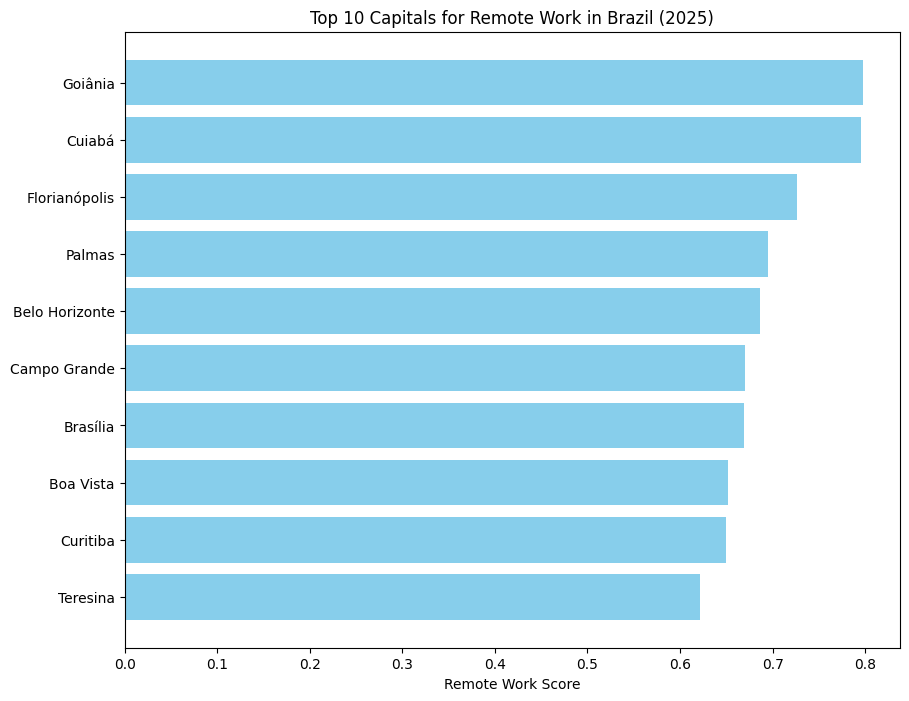

In [2]:
import matplotlib.pyplot as plt

top_10 = df_ranked.head(10)
plt.figure(figsize=(10, 8))
plt.barh(top_10['City'], top_10['Remote Work Score'], color='skyblue')
plt.xlabel('Remote Work Score')
plt.title('Top 10 Capitals for Remote Work in Brazil (2025)')
plt.gca().invert_yaxis()  # Show best at the top
plt.show()

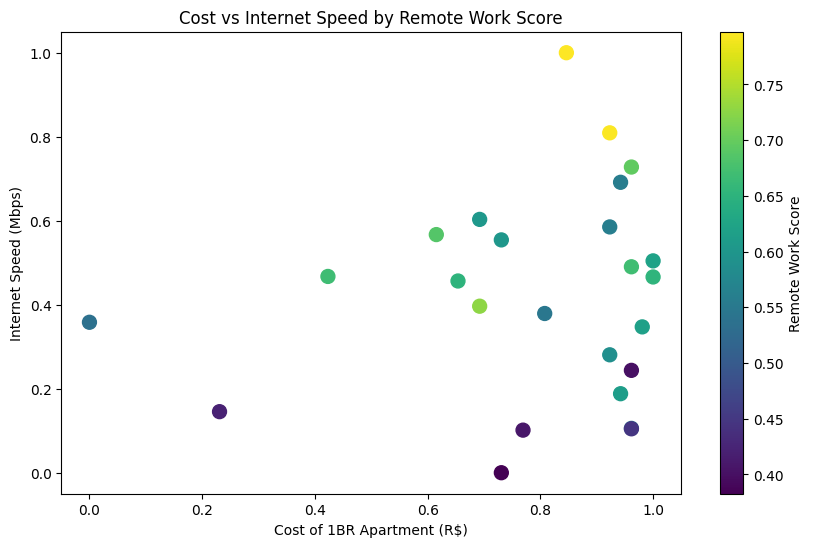

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_ranked['1BR Apartment (Center)'], df_ranked['speed_mbps'],
            c=df_ranked['Remote Work Score'], cmap='viridis', s=100)
plt.colorbar(label='Remote Work Score')
plt.xlabel('Cost of 1BR Apartment (R$)')
plt.ylabel('Internet Speed (Mbps)')
plt.title('Cost vs Internet Speed by Remote Work Score')
plt.show()